###  Modèle type LeNet ajout des blasts et smudge

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [2]:
data = pd.read_csv('../base_mendeley.csv',index_col=0)

In [3]:
data.head()

,file_path,filename,class,size
0,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_100102.jpg,basophil,363x360
1,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101381.jpg,basophil,363x360
2,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_101611.jpg,basophil,363x360
3,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102039.jpg,basophil,363x360
4,../images_mendeley/PBC_dataset_normal_DIB/baso...,BA_102750.jpg,basophil,363x360


In [4]:
data['class'].value_counts()

neutrophil      3329
eosinophil      3117
ig              2895
platelet        2348
erythroblast    1551
monocyte        1420
basophil        1218
lymphocyte      1214
Name: class, dtype: int64

In [5]:
data_train, data_eval = train_test_split(data,test_size=0.2,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.2,random_state=123)

#### Utilisation d'un ImageDataGenerator sans augmentation de données, charge seulement les images

In [6]:
def preprocess(x):
    img = x/255.
    return img

In [7]:
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(preprocessing_function=preprocess)

In [8]:
data_train_generator = data_generator.flow_from_dataframe(data_train, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

data_test_generator = data_generator.flow_from_dataframe(data_test, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

Found 10938 validated image filenames belonging to 8 classes.
Found 2735 validated image filenames belonging to 8 classes.


#### Modèle type LeNet
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam

In [9]:
# Création Callback pour stopper si stagnation et réduire learning rate
cb_early_stopping= EarlyStopping(monitor='val_loss', patience=6,restore_best_weights=True)
cb_lr = ReduceLROnPlateau(monitor='val_loss',
                                         patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='min')

In [10]:
# Création d'un modèle type LeNet
def model_LeNet():
    model =  Sequential()
    model.add(Conv2D(filters = 30  , kernel_size=(5,5), padding='valid', input_shape=(224,224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters = 16  , kernel_size=(3,3), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(units=1024,activation='relu'))
    model.add(Dense(units=512,activation='relu'))
    model.add(Dense(units=256,activation='relu'))
    model.add(Dense(units=8,activation='softmax')) #8 Classes
    #Compilation
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
model = model_LeNet()

In [12]:
#Entrainement
history = model.fit(data_train_generator, epochs = 16, batch_size=32, validation_data = data_test_generator,callbacks=[cb_early_stopping,cb_lr])

Epoch 1/16
342/342 [==============================] - 589s 2s/step - loss: 1.1555 - accuracy: 0.5913 - val_loss: 0.6232 - val_accuracy: 0.7682
Epoch 2/16
342/342 [==============================] - 609s 2s/step - loss: 0.5808 - accuracy: 0.7895 - val_loss: 0.4877 - val_accuracy: 0.8263
Epoch 3/16
342/342 [==============================] - 626s 2s/step - loss: 0.4421 - accuracy: 0.8427 - val_loss: 0.4650 - val_accuracy: 0.8366
Epoch 4/16
342/342 [==============================] - 639s 2s/step - loss: 0.3136 - accuracy: 0.8897 - val_loss: 0.4243 - val_accuracy: 0.8490
Epoch 5/16
342/342 [==============================] - 692s 2s/step - loss: 0.2292 - accuracy: 0.9227 - val_loss: 0.4693 - val_accuracy: 0.8512
Epoch 6/16
342/342 [==============================] - 725s 2s/step - loss: 0.1749 - accuracy: 0.9404 - val_loss: 0.4235 - val_accuracy: 0.8691
Epoch 7/16
342/342 [==============================] - 722s 2s/step - loss: 0.0903 - accuracy: 0.9675 - val_loss: 0.4444 - val_accuracy: 0.8614

#### Prédiction sur les données d'évaluation

In [13]:
data_eval_generator = data_generator.flow_from_dataframe(data_eval, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32,shuffle=False)

Found 3419 validated image filenames belonging to 8 classes.


In [14]:
model.evaluate(data_eval_generator)

107/107 [==============================] - 50s 464ms/step - loss: 0.4239 - accuracy: 0.8713


[0.4239363372325897, 0.871307373046875]

 * Score de 87%

In [15]:
#Prédiction
predict = model.predict(data_eval_generator)

In [16]:
#Classes prédites
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in data_eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.69      0.83      0.75       222
  eosinophil       0.97      0.93      0.95       627
erythroblast       0.96      0.80      0.87       311
          ig       0.69      0.86      0.77       590
  lymphocyte       0.95      0.79      0.86       236
    monocyte       0.86      0.60      0.71       302
  neutrophil       0.91      0.95      0.93       682
    platelet       1.00      0.99      1.00       449

    accuracy                           0.87      3419
   macro avg       0.88      0.84      0.85      3419
weighted avg       0.88      0.87      0.87      3419



> Rappel plus faible sur les IG toujours, ainsi que les monocytes

In [17]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Réalité,,,,,,,,
basophil,184,1,0,32,3,2,0,0
eosinophil,2,581,2,13,1,1,26,1
erythroblast,4,1,250,33,5,1,17,0
ig,36,3,4,505,1,22,19,0
lymphocyte,14,0,3,26,187,3,3,0
monocyte,24,1,0,96,0,181,0,0
neutrophil,3,10,1,23,0,0,645,0
platelet,0,1,1,0,0,0,1,446


> Confusion importante IG/Monocyte et ig/basophil

In [18]:
model.save_weights("lenet_8_mendeley")


### GRAD CAM

In [25]:
import gradcam

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 30)      2280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      4336      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4

In [21]:
img_size = (224, 224)
last_conv_layer_name = "conv2d_1"

##### BASOPHIL

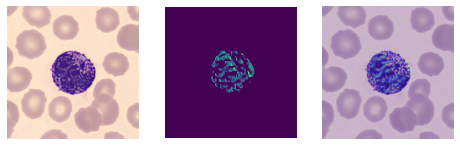

In [30]:
path = data[data['filename']=='BA_799126.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path,(224,224), model, last_conv_layer_name,pred_index=0)

##### EOSINOPHIL

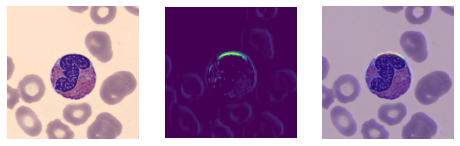

In [35]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=1)

##### ERYTHROBLAST

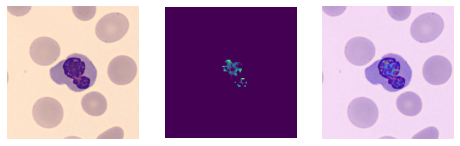

In [37]:
path = data[data['filename']=='ERB_763618.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=2)

##### IG

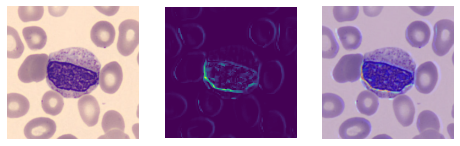

In [39]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=3)

##### LYMPHOCYTE

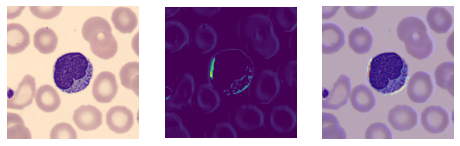

In [41]:
path = data[data['filename']=='LY_875873.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=4)

##### MONOCYTE

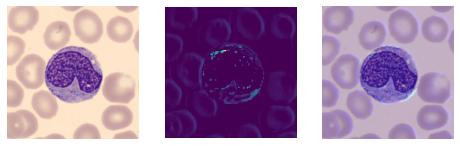

In [58]:
path = data[data['filename']=='MO_214087.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=5)

##### NEUTROPHIL

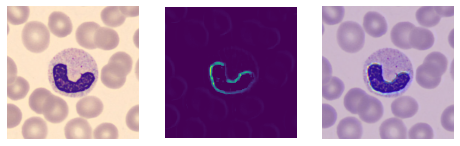

In [46]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=6)

##### PLATELET

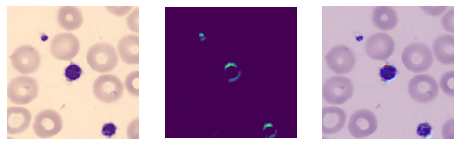

In [48]:
path = data[data['filename']=='PLATELET_57415.jpg']['file_path'].values[0]
gradcam.display_headmap(preprocess, path, (224,224),model, last_conv_layer_name,pred_index=7)